In [1]:
# Cell 1: Imports and Utility Functions

import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def compute_ssim(x, y):
    return tf.image.ssim(x, y, max_val=1.0)

def compute_psnr(x, y):
    return tf.image.psnr(x, y, max_val=1.0)

def show_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        if img.shape[-1] == 1:
            plt.imshow(tf.squeeze(img), cmap='gray')
        else:
            plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis("off")
    plt.show()


2025-06-08 19:46:08.015982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749411968.212877      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749411968.267917      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Cell 2: Data Loading and Text Rendering

IMG_SIZE = 256
BATCH_SIZE = 8

train_dir = '/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR'
val_dir   = '/kaggle/input/div2k-high-resolution-images/DIV2K_valid_HR/DIV2K_valid_HR'

train_cover_paths = sorted(glob.glob(train_dir + '/*.png'))
val_cover_paths   = sorted(glob.glob(val_dir   + '/*.png'))

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img

def render_text_to_image(text):
    img_size = (256, 256)
    bg_color = 0   # black background
    fg_color = 255 # white text

    img = Image.new('L', img_size, color=bg_color)   # 'L' = grayscale
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", size=20)
    except IOError:
        font = ImageFont.load_default()

    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    position = ((img_size[0] - text_width) // 2,
                (img_size[1] - text_height) // 2)
    draw.text(position, text, fill=fg_color, font=font)

    arr = np.array(img).astype(np.float32) / 255.0
    arr = (arr > 0.5).astype(np.float32)  # Binary mask thresholding
    arr = np.expand_dims(arr, axis=-1)   # shape (256,256,1)
    return arr


In [3]:
# Cell 3: Data Augmentation and Dataset Building (with text secrets)

def augment_pair(cover, secret):
    # Random horizontal flip (50% chance)
    flip = tf.random.uniform([]) > 0.5
    if flip:
        cover = tf.image.flip_left_right(cover)
        secret = tf.image.flip_left_right(secret)
    
    # Add more synchronized spatial augmentations here if needed (e.g., rotations)

    # Brightness augmentation only on cover
    cover = tf.image.random_brightness(cover, max_delta=0.1)

    return cover, secret

def build_text_dataset(image_paths, text_list, batch_size=8, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, text_list))

    def load_pair(path, text):
        cover = load_image(path)                              # (256,256,3)
        secret = tf.numpy_function(render_text_to_image, [text], tf.float32)
        secret.set_shape([IMG_SIZE, IMG_SIZE, 1])            # ensure shape (256,256,1)
        if training:
            cover, secret = augment_pair(cover, secret)
        combined = tf.concat([cover, secret], axis=-1)        # (256,256,4)
        return combined, (cover, secret)

    dataset = dataset.map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(500)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [4]:
# Cell 4: Transformer-based Encoder and Decoder Models

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_size=16, embed_dim=64):
        super().__init__()
        self.proj = tf.keras.layers.Conv2D(embed_dim, patch_size, patch_size)
        self.flatten = tf.keras.layers.Reshape((-1, embed_dim))

    def call(self, x):
        return self.flatten(self.proj(x))

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim=64, num_heads=4, mlp_dim=128, dropout=0.1):
        super().__init__()
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.attn  = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim, activation='gelu'),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(embed_dim),
            tf.keras.layers.Dropout(dropout),
        ])

    def call(self, x, training):
        x = x + self.attn(self.norm1(x), self.norm1(x))
        x = x + self.mlp(self.norm2(x), training=training)
        return x

class Encoder(tf.keras.Model):
    def __init__(self, embed_dim=64, patch_size=16, num_blocks=4):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size, embed_dim)
        self.blocks = [TransformerBlock(embed_dim) for _ in range(num_blocks)]
        self.embed_dim = embed_dim

    def call(self, x, training=False):
        x = self.patch_embed(x)
        for block in self.blocks:
            x = block(x, training=training)
        B = tf.shape(x)[0]
        H = W = IMG_SIZE // 16
        return tf.reshape(x, (B, H, W, self.embed_dim))

# Decoder (ViT Output to Stego and Recovered Secret)
# Decoder (ViT Output to Stego and Recovered Secret)
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.deconv1 = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')  # 16x16 → 32x32
        self.deconv2 = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')   # 32x32 → 64x64
        self.deconv3 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')   # 64x64 → 128x128
        self.deconv4 = tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')   # 128x128 → 256x256

        # Updated stego head: tanh and rescale in call()
        self.stego_out = tf.keras.layers.Conv2D(3, 3, padding='same', activation='tanh')  # Output RGB
        self.secret_out = tf.keras.layers.Conv2D(1, 3, padding='same', activation='sigmoid')  # Output single-channel mask

    def call(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)

        stego = self.stego_out(x)
        stego = (stego + 1) / 2  # Rescale tanh output from [-1, 1] → [0, 1]

        secret = self.secret_out(x)
        return stego, secret


In [5]:
# Cell 5: Instantiate Models, Optimizer, Losses, Metrics, and Training/Validation Steps

encoder = Encoder()
decoder = Decoder()

optimizer = tf.keras.optimizers.Adam(1e-4)
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

train_loss     = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
train_ssim     = tf.keras.metrics.Mean(name='train_ssim')
train_psnr     = tf.keras.metrics.Mean(name='train_psnr')

val_loss     = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')
val_ssim     = tf.keras.metrics.Mean(name='val_ssim')
val_psnr     = tf.keras.metrics.Mean(name='val_psnr')

# Helper to compute edge-aware loss using Sobel filters
def compute_high_freq_loss(x, y):
    sobel_x = tf.image.sobel_edges(x)
    sobel_y = tf.image.sobel_edges(y)
    return tf.reduce_mean(tf.square(sobel_x - sobel_y))

@tf.function
def train_step(cover, secret):
    with tf.GradientTape() as tape:
        concat_input = tf.concat([cover, secret], axis=-1)
        encoded = encoder(concat_input, training=True)
        stego, recovered_secret = decoder(encoded, training=True)

        cover_loss   = mse_loss(cover, stego)
        secret_loss  = bce_loss(secret, recovered_secret)
        high_freq_loss = compute_high_freq_loss(cover, stego)

        total_loss = secret_loss * 1.0 + cover_loss * 5.0 + high_freq_loss * 2.0

    grads = tape.gradient(total_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

    train_loss.update_state(total_loss)
    train_ssim.update_state(tf.image.ssim(secret, recovered_secret, max_val=1.0))
    train_psnr.update_state(tf.image.psnr(secret, recovered_secret, max_val=1.0))
    train_accuracy.update_state(secret, tf.round(recovered_secret))

@tf.function
def val_step(cover, secret):
    concat_input = tf.concat([cover, secret], axis=-1)
    encoded = encoder(concat_input, training=False)
    stego, recovered_secret = decoder(encoded, training=False)

    cover_loss   = mse_loss(cover, stego)
    secret_loss  = bce_loss(secret, recovered_secret)
    high_freq_loss = compute_high_freq_loss(cover, stego)

    total_loss = secret_loss * 1.0 + cover_loss * 5.0 + high_freq_loss * 2.0

    val_loss.update_state(total_loss)
    val_ssim.update_state(tf.image.ssim(secret, recovered_secret, max_val=1.0))
    val_psnr.update_state(tf.image.psnr(secret, recovered_secret, max_val=1.0))
    val_accuracy.update_state(secret, tf.round(recovered_secret))


I0000 00:00:1749411983.039661      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
# Cell 6: Prepare your text secrets and datasets

# Example secret texts — match length to dataset size or batch size
secret_texts_train = [
    "Hello, world!",
    "Secret message 1",
    "Hidden text data",
    "Another secret",
    "Sample secret text",
    "SteganoGAN rocks!",
    "Embedding text",
    "Text to image secret",
] * (len(train_cover_paths) // 8 + 1)  # Repeat or adjust length to match dataset size

secret_texts_val = [
    "Validation text 1",
    "Secret val message",
    "Hidden val data",
    "Val secret text",
    "Another val secret",
    "Val SteganoGAN!",
    "Val embed text",
    "Val text secret",
] * (len(val_cover_paths) // 8 + 1)

# Trim to exact length
secret_texts_train = secret_texts_train[:len(train_cover_paths)]
secret_texts_val   = secret_texts_val[:len(val_cover_paths)]

train_dataset = build_text_dataset(train_cover_paths, secret_texts_train, batch_size=BATCH_SIZE, training=True)
val_dataset = build_text_dataset(val_cover_paths, secret_texts_val, batch_size=BATCH_SIZE, training=False)


In [7]:
import tensorflow as tf

def compute_f1(y_true, y_pred, epsilon=1e-7):
    """
    Compute the F1 score for binary tensors.
    
    Args:
        y_true: ground truth binary tensor.
        y_pred: predicted binary tensor.
        epsilon: small constant to avoid division by zero.
    
    Returns:
        f1: scalar tensor with F1 score.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred)            # true positives
    fp = tf.reduce_sum(y_pred) - tp                 # false positives
    fn = tf.reduce_sum(y_true) - tp                 # false negatives
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    return f1


In [8]:
# Define compute_f1 function (simple batch-level F1 score calculation)
def compute_f1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    tp = tf.reduce_sum(tf.cast(tf.logical_and(y_true, y_pred), tf.float32))
    fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(y_true), y_pred), tf.float32))
    fn = tf.reduce_sum(tf.cast(tf.logical_and(y_true, tf.logical_not(y_pred)), tf.float32))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return f1

# Initialize history dictionary to store metrics for each epoch
history = {
    'train_loss': [],
    'train_acc': [],
    'train_ssim': [],
    'train_psnr': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_ssim': [],
    'val_psnr': [],
    'val_f1': [],
}

EPOCHS = 50

for epoch in range(EPOCHS):
    # Reset all metrics
    for metric in [train_loss, train_accuracy, train_ssim, train_psnr,
                   val_loss, val_accuracy, val_ssim, val_psnr]:
        metric.reset_state()

    train_f1_metric = tf.keras.metrics.Mean(name='train_f1')
    val_f1_metric   = tf.keras.metrics.Mean(name='val_f1')

    # ----- Training -----
    for step, (combined, (cover, secret)) in enumerate(train_dataset):
        # 1) update weights & cover/secret metrics
        train_step(cover, secret)

        # 2) forward pass to get recovered_secret
        concat_input        = tf.concat([cover, secret], axis=-1)
        encoded             = encoder(concat_input, training=True)
        _, recovered_secret = decoder(encoded, training=True)

        # compute batch-level F1
        pred_binary = tf.round(recovered_secret)
        true_binary = tf.round(secret)
        batch_f1    = compute_f1(true_binary, pred_binary)
        train_f1_metric.update_state(batch_f1)

        if step % 10 == 0:
            print(
                f"Epoch {epoch+1} Step {step}: "
                f"Loss={train_loss.result():.4f}, "
                f"Acc={train_accuracy.result():.4f}, "
                f"SSIM={train_ssim.result():.4f}, "
                f"PSNR={train_psnr.result():.4f}, "
                f"F1={train_f1_metric.result():.4f}"
            )

    # ----- Validation -----
    for combined, (cover, secret) in val_dataset:
        # 1) update val-metrics
        val_step(cover, secret)

        # 2) forward pass to get recovered_secret
        concat_input        = tf.concat([cover, secret], axis=-1)
        encoded             = encoder(concat_input, training=False)
        _, recovered_secret = decoder(encoded, training=False)

        pred_binary = tf.round(recovered_secret)
        true_binary = tf.round(secret)
        batch_f1    = compute_f1(true_binary, pred_binary)
        val_f1_metric.update_state(batch_f1)

    # epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(
        f" Train -> Loss: {train_loss.result():.4f}, "
        f"Acc: {train_accuracy.result():.4f}, "
        f"SSIM: {train_ssim.result():.4f}, "
        f"PSNR: {train_psnr.result():.4f}, "
        f"F1: {train_f1_metric.result():.4f}"
    )
    print(
        f" Val   -> Loss: {val_loss.result():.4f}, "
        f"Acc: {val_accuracy.result():.4f}, "
        f"SSIM: {val_ssim.result():.4f}, "
        f"PSNR: {val_psnr.result():.4f}, "
        f"F1: {val_f1_metric.result():.4f}\n"
    )

    # append to history
    history['train_loss'].append(train_loss.result().numpy())
    history['train_acc'].append(train_accuracy.result().numpy())
    history['train_ssim'].append(train_ssim.result().numpy())
    history['train_psnr'].append(train_psnr.result().numpy())
    history['train_f1'].append(train_f1_metric.result().numpy())

    history['val_loss'].append(val_loss.result().numpy())
    history['val_acc'].append(val_accuracy.result().numpy())
    history['val_ssim'].append(val_ssim.result().numpy())
    history['val_psnr'].append(val_psnr.result().numpy())
    history['val_f1'].append(val_f1_metric.result().numpy())


I0000 00:00:1749412017.725551      80 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1 Step 0: Loss=1.5327, Acc=0.8057, SSIM=0.0005, PSNR=6.1289, F1=0.0052
Epoch 1 Step 10: Loss=1.6070, Acc=0.8860, SSIM=0.0005, PSNR=6.2722, F1=0.0048
Epoch 1 Step 20: Loss=1.5780, Acc=0.9285, SSIM=0.0005, PSNR=6.4929, F1=0.0047
Epoch 1 Step 30: Loss=1.5603, Acc=0.9496, SSIM=0.0005, PSNR=6.8334, F1=0.0039
Epoch 1 Step 40: Loss=1.5286, Acc=0.9611, SSIM=0.0005, PSNR=7.3096, F1=0.0030
Epoch 1 Step 50: Loss=1.5075, Acc=0.9681, SSIM=0.0005, PSNR=7.8617, F1=0.0024
Epoch 1 Step 60: Loss=1.4716, Acc=0.9728, SSIM=0.0005, PSNR=8.5515, F1=0.0020
Epoch 1 Step 70: Loss=1.4380, Acc=0.9762, SSIM=0.0007, PSNR=9.3925, F1=0.0017
Epoch 1 Step 80: Loss=1.3967, Acc=0.9788, SSIM=0.0012, PSNR=10.3241, F1=0.0015
Epoch 1 Step 90: Loss=1.3529, Acc=0.9808, SSIM=0.0035, PSNR=11.3113, F1=0.0013

Epoch 1 Summary:
 Train -> Loss: 1.3264, Acc: 0.9822, SSIM: 0.0126, PSNR: 12.1105, F1: 0.0012
 Val   -> Loss: 0.9877, Acc: 0.9972, SSIM: 0.2285, PSNR: 21.9889, F1: 0.0000

Epoch 2 Step 0: Loss=1.0257, Acc=0.9972, SSIM=

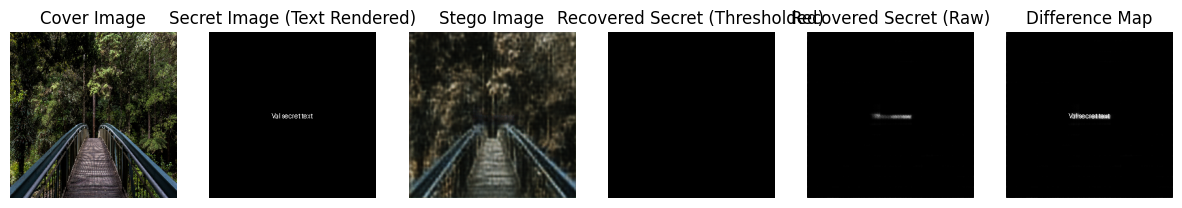

In [9]:
import random

# Cell 8: Visualize Predictions on Random Validation Sample

for combined, (cover_batch, secret_batch) in val_dataset.shuffle(1000).take(1):  # Shuffle to get a random batch
    # Choose a random index within the batch
    idx = random.randint(0, cover_batch.shape[0] - 1)

    concat_input = tf.concat([cover_batch, secret_batch], axis=-1)
    encoded = encoder(concat_input, training=False)
    stego_image, recovered_secret = decoder(encoded, training=False)

    recovered_secret_binary = tf.cast(recovered_secret > 0.5, tf.float32)
    diff = tf.abs(secret_batch[idx] - recovered_secret[idx])
    diff = tf.clip_by_value(diff * 5.0, 0.0, 1.0)

    show_images([
        cover_batch[idx],
        secret_batch[idx],
        stego_image[idx],
        recovered_secret_binary[idx],
        recovered_secret[idx],
        diff
    ], titles=[
        "Cover Image",
        "Secret Image (Text Rendered)",
        "Stego Image",
        "Recovered Secret (Thresholded)",
        "Recovered Secret (Raw)",
        "Difference Map"
    ])


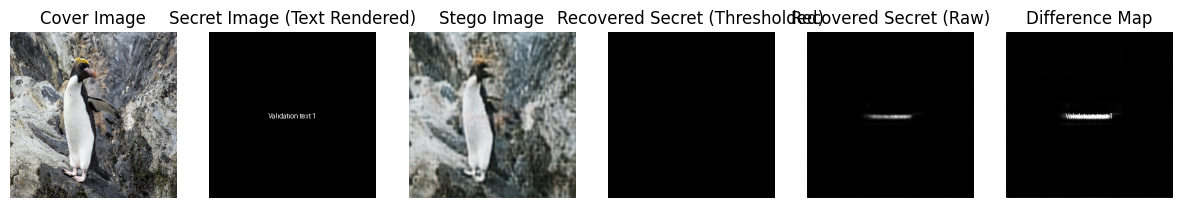

In [10]:
# Cell 8: Visualize Predictions on Validation Batch

for combined, (cover_batch, secret_batch) in val_dataset.take(1):
    # Forward pass
    concat_input = tf.concat([cover_batch, secret_batch], axis=-1)
    encoded = encoder(concat_input, training=False)
    stego_image, recovered_secret = decoder(encoded, training=False)

    # Threshold secret to visualize clearly
    recovered_secret_binary = tf.cast(recovered_secret > 0.5, tf.float32)

    # Difference image (for visual debugging)
    diff = tf.abs(secret_batch[0] - recovered_secret[0])
    diff = tf.clip_by_value(diff * 5.0, 0.0, 1.0)  # amplify difference for visibility

    # Display all relevant components
    show_images([
        cover_batch[0],
        secret_batch[0],
        stego_image[0],
        recovered_secret_binary[0],
        recovered_secret[0],
        diff
    ], titles=[
        "Cover Image",
        "Secret Image (Text Rendered)",
        "Stego Image",
        "Recovered Secret (Thresholded)",
        "Recovered Secret (Raw)",
        "Difference Map"
    ])


In [13]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(16, 12))
    
    # Loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(3, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # SSIM
    plt.subplot(3, 2, 3)
    plt.plot(epochs, history['train_ssim'], label='Train SSIM')
    plt.plot(epochs, history['val_ssim'], label='Val SSIM')
    plt.title('SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    
    # PSNR
    plt.subplot(3, 2, 4)
    plt.plot(epochs, history['train_psnr'], label='Train PSNR')
    plt.plot(epochs, history['val_psnr'], label='Val PSNR')
    plt.title('PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    
    # F1 Score
    plt.subplot(3, 2, 5)
    plt.plot(epochs, history['train_f1'], label='Train F1 Score')
    plt.plot(epochs, history['val_f1'], label='Val F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


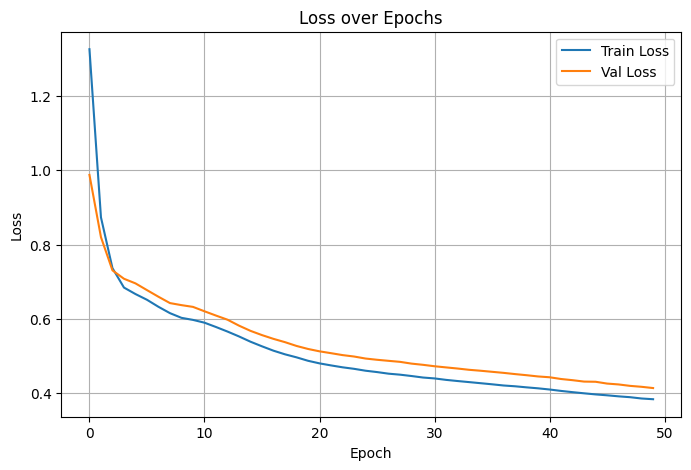

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()


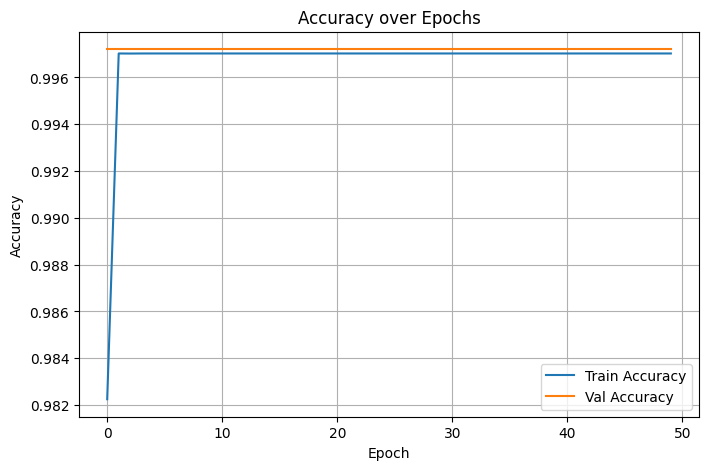

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()


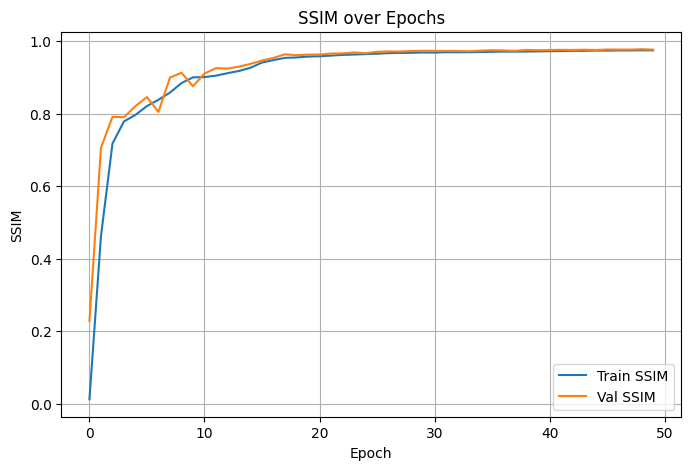

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(history['train_ssim'], label='Train SSIM')
plt.plot(history['val_ssim'], label='Val SSIM')
plt.title('SSIM over Epochs')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.grid(True)
plt.savefig('ssim_plot.png')
plt.show()


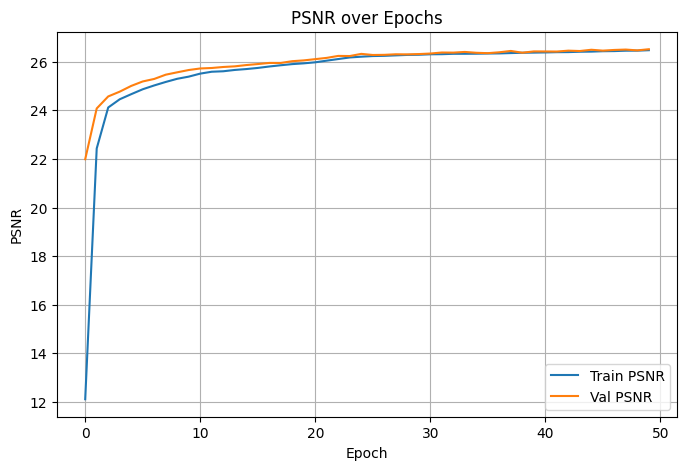

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(history['train_psnr'], label='Train PSNR')
plt.plot(history['val_psnr'], label='Val PSNR')
plt.title('PSNR over Epochs')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.savefig('psnr_plot.png')
plt.show()


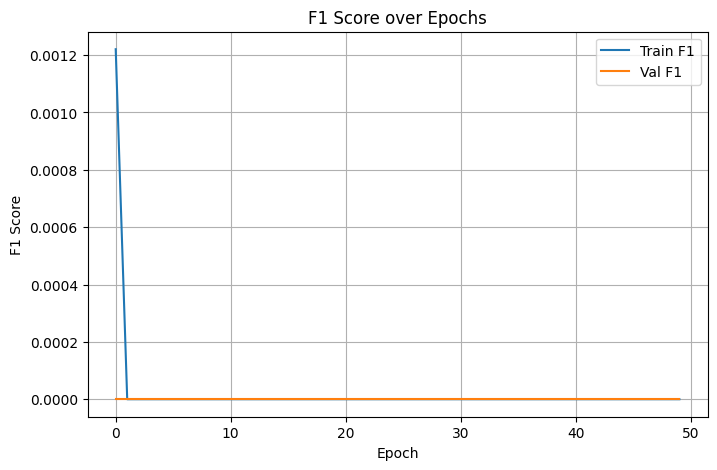

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Val F1')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('f1_plot.png')
plt.show()


In [24]:
from IPython.display import FileLink

# Example: download one plot
FileLink('psnr_plot.png')  # Do the same for 'loss_plot.png', etc.


/kaggle/working/psnr_plot.png